In [9]:
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pyplot as plt
from PIL import Image
from tifffile import imread

In [10]:

model_name = "facebook/dinov3-vitl16-pretrain-sat493m"  # smaller + sat-trained

processor = AutoImageProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).eval().to(device)

print("device:", device)

device: cuda


In [11]:
#load incomplite unrefined labels

labels = imread("/run/media/mak/Partition of 1TB disk/SH_dataset/planet_labels_2022.tif")
image = imread("/home/mak/PycharmProjects/SegEdge/experiments/get_data_from_api/patches_mt/dop20_593000_5982000_1km_20cm.tif")

image.shape, labels.shape

((5000, 5000, 3), (49152, 36864))

crs: EPSG:25832  transform: | 0.20, 0.00, 593000.00|
| 0.00,-0.20, 5983000.00|
| 0.00, 0.00, 1.00|  size: (5000, 5000)  bands: 3


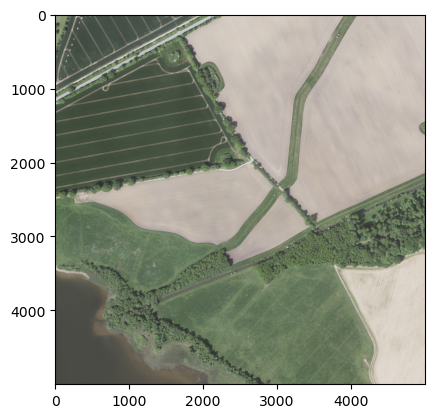

In [12]:
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.windows import Window

img_path = "/home/mak/PycharmProjects/SegEdge/experiments/get_data_from_api/patches_mt/dop20_593000_5982000_1km_20cm.tif"
img2 = "/home/mak/PycharmProjects/SegEdge/experiments/get_data_from_api/patches_mt/dop20_592000_5982000_1km_20cm.tif"

with rasterio.open(img_path) as img1:
    # Basic metadata
    crs = img1.crs                 # e.g., EPSG:25832 for German DOP20 tiles [web:60]

    transform = img1.transform     # Affine mapping pixel -> map coords [web:60]
    width, height = img1.width, img1.height  # pixel dimensions [web:61]
    count = img1.count             # number of bands [web:61]
    bounds = img1.bounds           # left, bottom, right, top in CRS units [web:40]

    # Read all bands into array shaped (bands, H, W)
    arr = img1.read()              # preserves dtype; no normalization [web:40]
    print("crs:", crs, " transform:", transform, " size:", (width, height), " bands:", count)

# If you want HxWxC for visualization:
img = reshape_as_image(arr)       # converts (C,H,W) -> (H,W,C) [web:40]

#print image
plt.imshow(img)

reprojected labels shape: (1, 5000, 5000)


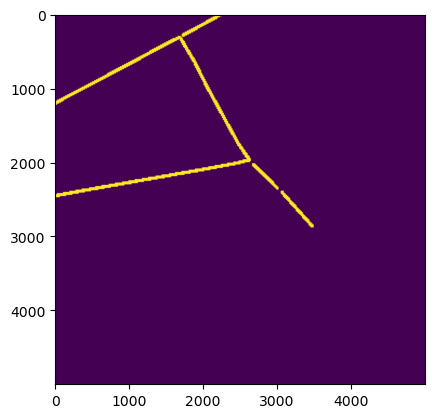

In [13]:
import rasterio
from rasterio.warp import reproject, Resampling

lab_path = "/run/media/mak/Partition of 1TB disk/SH_dataset/planet_labels_2022.tif"

with rasterio.open(img_path) as ref, rasterio.open(lab_path) as img1:
    dst_meta = ref.meta.copy()
    dst_meta.update(dtype=img1.dtypes[0], count=img1.count)  # keep label dtype/bands [web:65]
    labels_on_img = rasterio.io.MemoryFile().open(**dst_meta)
    for i in range(1, img1.count + 1):
        dest = rasterio.band(labels_on_img, i)
        reproject(
            source=rasterio.band(img1, i),
            destination=dest,
            src_transform=img1.transform, src_crs=img1.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            dst_width=ref.width, dst_height=ref.height,
            resampling=Resampling.nearest,  # categorical labels [web:65][web:74]
        )
    # read to array if needed
    labels_arr = labels_on_img.read()  # shape (bands, H, W) aligned to image [web:65]
    print("reprojected labels shape:", labels_arr.shape)


plt.imshow(labels_arr[0])


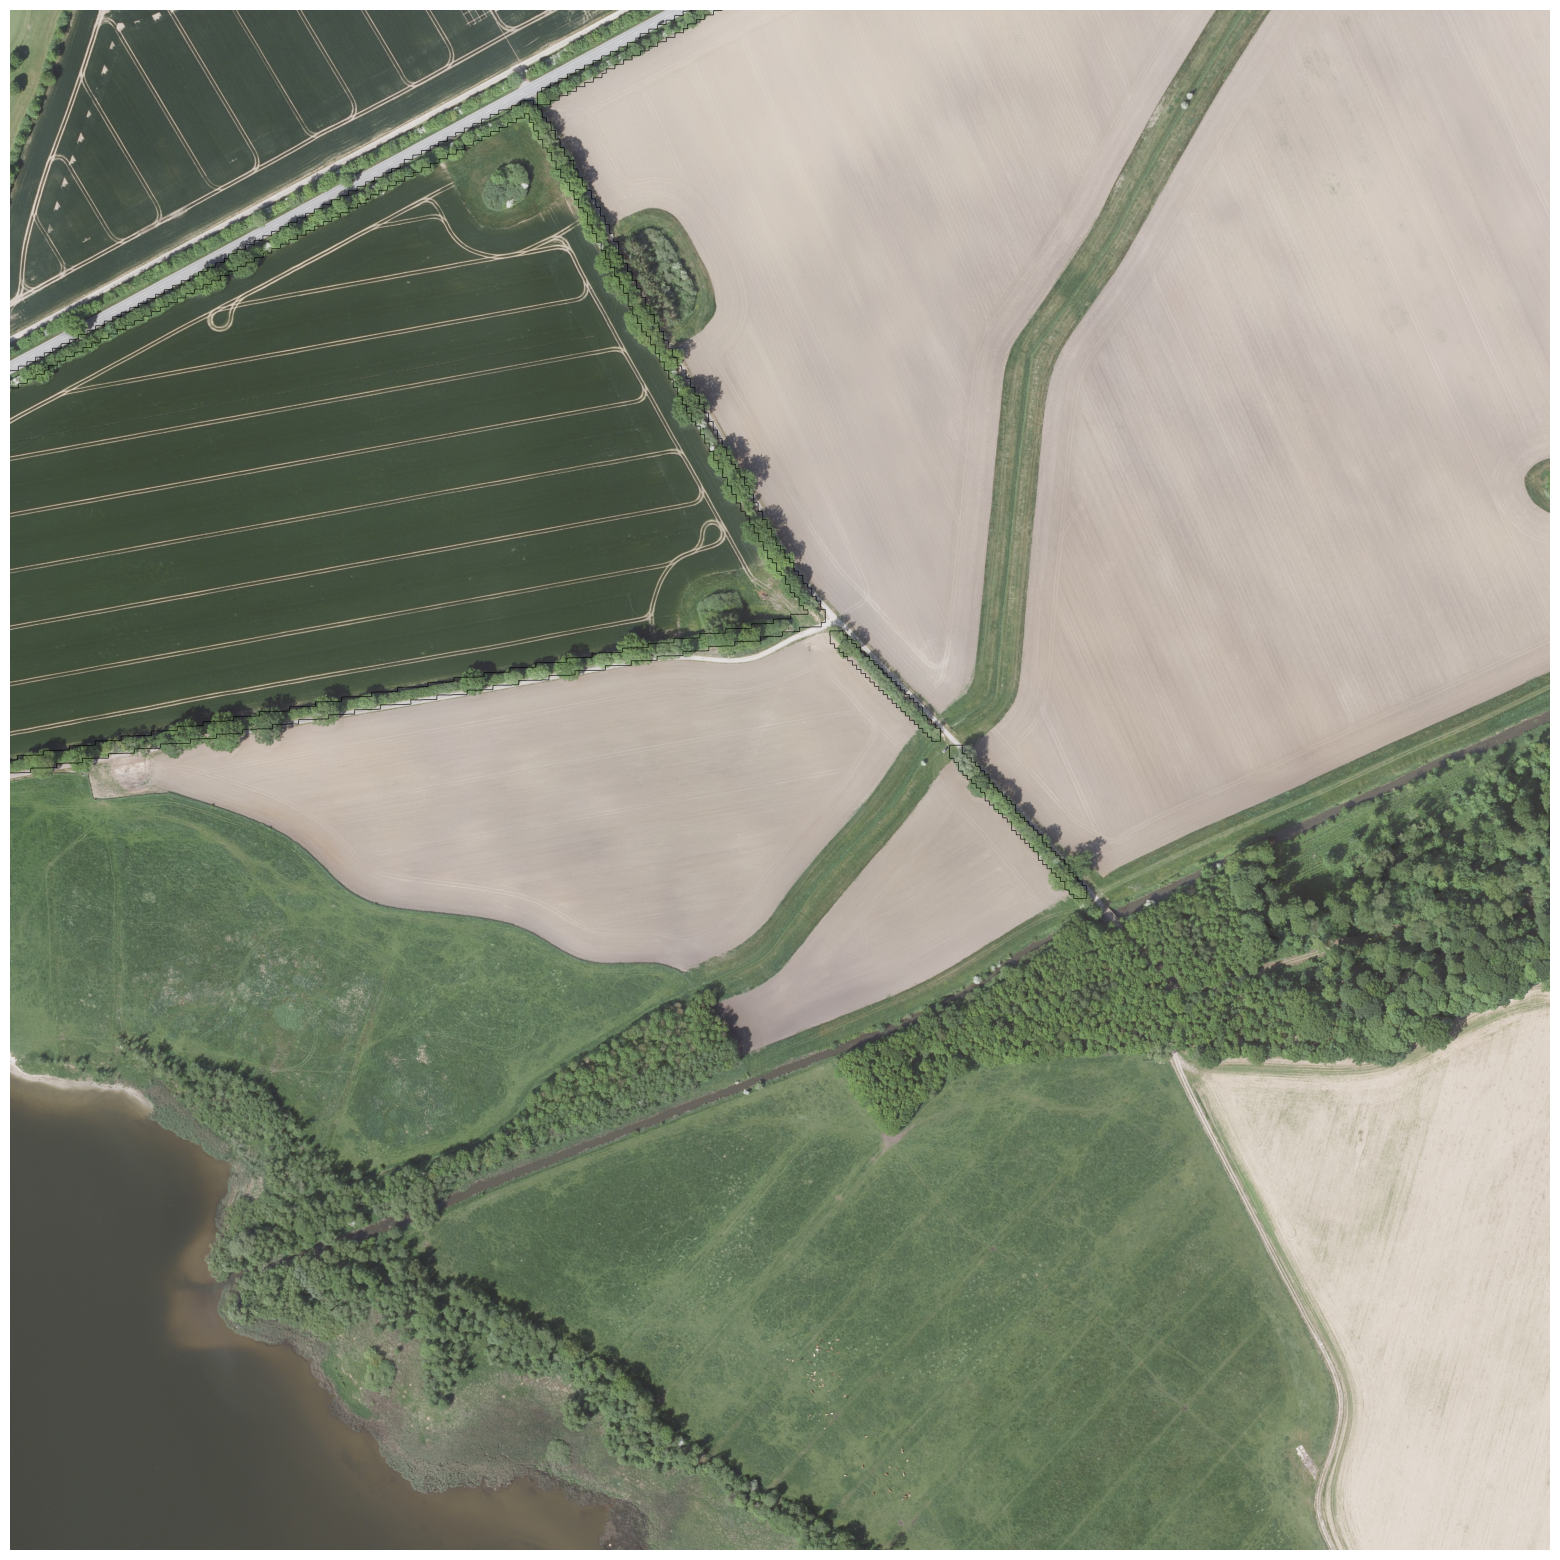

In [14]:
from skimage.segmentation import find_boundaries

# labels_arr is shape (1, H, W) but find_boundaries expects (H, W)
# Extract the first band to get 2D array
labels_2d = labels_arr[0]  # now shape (H, W)

boundaries = find_boundaries(labels_2d, mode='thick')  # binary mask of edges
overlay = img.copy()
overlay[boundaries] = [0, 0, 0]

plt.figure(figsize=(20,20))
plt.imshow(overlay)
plt.axis('off')
plt.show()


Processed input shape: torch.Size([1, 3, 224, 224])
Total patches: 200, hidden_dim: 1024
Processed image: 224x224
Patch size: 16
Calculated patch grid: 14x14 = 196 patches
Actual patches from model: 200
Adjusted patch grid based on aspect ratio: 14x14
Features to cluster: (200, 1024)


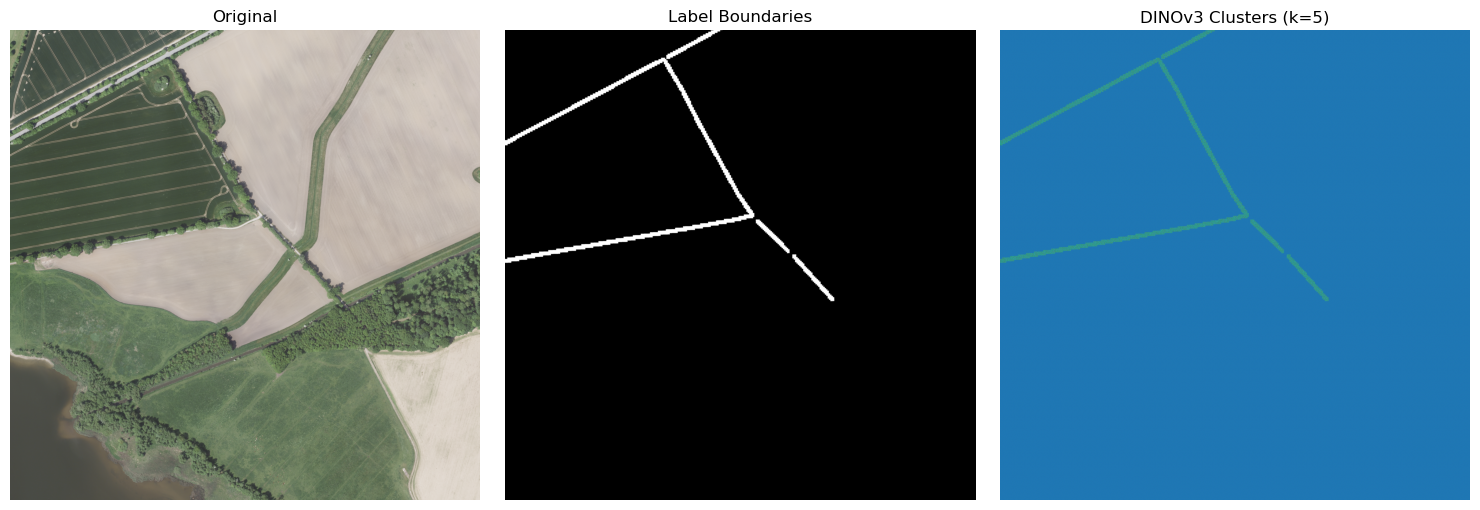

Unique clusters: [0 1 2 3 4]


In [15]:
import torch
import numpy as np
from sklearn.cluster import KMeans

# Extract patch features from DINOv3
inputs = processor(images=img, return_tensors="pt").to(device)

# Check what size the processor actually created
print(f"Processed input shape: {inputs['pixel_values'].shape}")  # (1, 3, H, W)

with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state  # (1, 1 + num_patches, hidden_dim)

# Remove CLS token
patch_features = last_hidden_states[:, 1:, :]  # (1, num_patches, hidden_dim)
batch_size, num_patches, hidden_dim = patch_features.shape
print(f"Total patches: {num_patches}, hidden_dim: {hidden_dim}")

# Get actual processed image dimensions from processor
processed_h = inputs['pixel_values'].shape[2]
processed_w = inputs['pixel_values'].shape[3]
patch_size = model.config.patch_size

# Calculate correct patch grid dimensions (may not be square!)
num_patches_h = processed_h // patch_size
num_patches_w = processed_w // patch_size
expected_patches = num_patches_h * num_patches_w

print(f"Processed image: {processed_h}x{processed_w}")
print(f"Patch size: {patch_size}")
print(f"Calculated patch grid: {num_patches_h}x{num_patches_w} = {expected_patches} patches")
print(f"Actual patches from model: {num_patches}")

# If they don't match, the image might be rectangular or have register tokens
# Work directly with flattened patches
patch_features_flat = patch_features[0].cpu().numpy()  # (num_patches, hidden_dim)

# Create a simple spatial mask: resize label mask to approximate patch layout
# Use the actual num_patches to guess dimensions
if num_patches == 200:  # Common case: 10x20 or 20x10 or adjust based on aspect ratio
    aspect_ratio = img.shape[1] / img.shape[0]  # W/H
    num_patches_h = int(np.sqrt(num_patches / aspect_ratio))
    num_patches_w = num_patches // num_patches_h
    print(f"Adjusted patch grid based on aspect ratio: {num_patches_h}x{num_patches_w}")

# Verify
if num_patches_h * num_patches_w != num_patches:
    print(f"WARNING: Grid mismatch! Using flattened approach instead.")
    # Fallback: cluster ALL patches, no spatial filtering
    features_inside = patch_features_flat
else:
    # Reshape to spatial grid
    patch_features_2d = patch_features_flat.reshape(num_patches_h, num_patches_w, hidden_dim)

    # Downsample label mask to match the patch grid
    from skimage.transform import resize
    mask_patches = resize(labels_2d.astype(float) > 0,
                         (num_patches_h, num_patches_w),
                         order=0, anti_aliasing=False) > 0.5

    # Extract features only from patches inside boundaries
    features_inside = patch_features_2d[mask_patches]

print(f"Features to cluster: {features_inside.shape}")

# Cluster with k-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_inside)

# Create cluster map at patch resolution
if num_patches_h * num_patches_w == num_patches:
    cluster_map = np.zeros((num_patches_h, num_patches_w), dtype=int)
    cluster_map[mask_patches] = cluster_labels + 1

    # Upsample to original image size
    from skimage.transform import resize
    cluster_map_full = resize(cluster_map.astype(float),
                              (img.shape[0], img.shape[1]),
                              order=0, preserve_range=True, anti_aliasing=False).astype(int)
else:
    # Fallback: create a simple visualization
    cluster_map_full = np.zeros((img.shape[0], img.shape[1]), dtype=int)
    cluster_map_full[labels_2d > 0] = np.random.choice(cluster_labels, size=(labels_2d > 0).sum())

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(labels_2d > 0, cmap='gray')
plt.title("Label Boundaries")
plt.axis('off')

plt.subplot(133)
plt.imshow(cluster_map_full, cmap='tab10')
plt.title(f"DINOv3 Clusters (k={n_clusters})")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Unique clusters: {np.unique(cluster_labels)}")


In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from skimage.transform import resize
from skimage.morphology import erosion, disk
import matplotlib.pyplot as plt

# --------------- helpers (unchanged) ---------------
def factor_hw(n, ratio):
    best = (1, n)
    best_err = float('inf')
    for h in range(1, int(np.sqrt(n)) + 1):
        if n % h == 0:
            w = n // h
            err = abs((h / w) - ratio)
            if err < best_err:
                best = (h, w)
                best_err = err
    return best

def l2_normalize(feats, eps=1e-8):
    norms = np.linalg.norm(feats, axis=-1, keepdims=True) + eps
    return feats / norms

# --------------- projection head for embedding learning ---------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, in_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # L2 normalize embedding for cosine
        return F.normalize(x, dim=-1)

# --------------- feature extraction (unchanged except output now torch tensor) ---------------
def extract_patch_features(image_hw3, model, processor, device, aggregate_layers=None):
    inputs = processor(images=image_hw3, return_tensors="pt").to(device)
    Hproc, Wproc = inputs["pixel_values"].shape[2], inputs["pixel_values"].shape[3]

    with torch.no_grad():
        if aggregate_layers is None:
            out = model(**inputs)
            tokens = out.last_hidden_state
        else:
            out = model(**inputs, output_hidden_states=True)
            hs = out.hidden_states
            layers = [hs[i] for i in aggregate_layers]
            tokens = torch.stack(layers, dim=0).mean(0)

    R = getattr(model.config, "num_register_tokens", 0)
    patch_tokens = tokens[:, 1 + R:, :]
    N, C = patch_tokens.shape[1], patch_tokens.shape[2]
    ps = model.config.patch_size

    Hp_guess, Wp_guess = Hproc // ps, Wproc // ps
    if Hp_guess * Wp_guess != N:
        Hp, Wp = factor_hw(N, ratio=Hproc / Wproc)
    else:
        Hp, Wp = Hp_guess, Wp_guess

    feats = patch_tokens[0].cpu()  # tensor shape (N, C)
    feats_np = feats.numpy().reshape(Hp, Wp, C)
    feats_np = l2_normalize(feats_np)
    # Return both torch tensor and numpy for training/inference
    return feats, Hp, Wp, (Hproc, Wproc)

# --------------- prepare banks (positives + negatives) from Image A ---------------
def build_banks(img_a, labels_a, model, processor, device, erode_pixels=2, aggregate_layers=None):
    featsA_t, HpA, WpA, _ = extract_patch_features(img_a, model, processor, device,
                                                   aggregate_layers=aggregate_layers)
    # Mask positive patches
    mask_interior = erosion((labels_a > 0).astype(bool), disk(erode_pixels))
    mask_patches_pos = resize(mask_interior.astype(float),(HpA, WpA),
                               order=0, preserve_range=True, anti_aliasing=False)>0.5
    pos_feats = featsA_t[mask_patches_pos.reshape(-1), :]  # tensor shape (Npos, C)

    # Mask negative patches (background)
    mask_background = resize((labels_a == 0).astype(float),(HpA, WpA),
                             order=0, preserve_range=True, anti_aliasing=False)>0.5
    neg_feats = featsA_t[mask_background.reshape(-1), :]  # tensor shape (Nneg, C)

    return pos_feats, neg_feats, (HpA, WpA), mask_patches_pos

# --------------- train projection head ---------------
def train_projection_head(pos_feats, neg_feats, in_dim, device,
                          projection_dim=128, lr=1e-4, epochs=100, batch_size=256):
    # Combine pos & neg labels: pos=1, neg=0
    X = torch.cat([pos_feats, neg_feats], dim=0)  # (Npos+Nneg, C)
    y = torch.cat([torch.ones(len(pos_feats), dtype=torch.long),
                   torch.zeros(len(neg_feats), dtype=torch.long)], dim=0).to(device)

    # Move X to device
    X = X.to(device)

    head = ProjectionHead(in_dim, projection_dim).to(device)
    optimizer = torch.optim.Adam(head.parameters(), lr=lr)

    # Use simple supervised contrastive/triplet style training – here we just use binary classification + cosine
    criterion = nn.CrossEntropyLoss()  # you might replace with metric loss later

    for epoch in range(epochs):
        perm = torch.randperm(X.size(0))
        for i in range(0, X.size(0), batch_size):
            idx = perm[i:i + batch_size]
            batch = X[idx]
            labels = y[idx]
            emb = head(batch)  # (batch_size, projection_dim)
            # compute logits as cosine similarity matrix
            logits = torch.matmul(emb, emb.t())  # (B, B)
            # optionally scale (temperature)
            logits = logits / 0.1
            loss = criterion(logits, labels)  # simplistic
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.4f}")

    return head

# --------------- modified zero-shot transfer using learned embedding ---------------
def run_zero_shot_transfer_learned(
    img_a, labels_a, img_b, model, processor, device,
    k=5, threshold=0.75, erode_pixels=2, aggregate_layers=None,
    projection_head=None
):
    # Build banks
    pos_feats, neg_feats, (HpA, WpA), mask_patches_A = build_banks(
        img_a, labels_a, model, processor, device,
        erode_pixels=erode_pixels, aggregate_layers=aggregate_layers
    )
    print(f"Positive bank size: {len(pos_feats)}")

    # Train projection head (once)
    in_dim = pos_feats.shape[1]
    if projection_head is None:
        projection_head = train_projection_head(pos_feats, neg_feats, in_dim, device)

    # Build bank in embedding space
    with torch.no_grad():
        bank_embeddings = projection_head(pos_feats.to(device)).cpu().numpy()  # (Npos, D)

    # Extract features from image B
    featsB_t, HpB, WpB, _ = extract_patch_features(img_b, model, processor, device, aggregate_layers=aggregate_layers)
    featsB = featsB_t.cpu().numpy().reshape(-1, featsB_t.shape[-1])

    # Project B features
    with torch.no_grad():
        featsB_proj = projection_head(torch.from_numpy(featsB).to(device)).detach().cpu().numpy()


    # kNN search
    nn = NearestNeighbors(n_neighbors=min(k, max(1, bank_embeddings.shape[0])),
                          metric="cosine", algorithm="brute")
    nn.fit(bank_embeddings)
    dists, _ = nn.kneighbors(featsB_proj, return_distance=True)
    sims = 1.0 - dists
    score = sims.mean(axis=1)
    score_map = score.reshape(HpB, WpB)

    Hb, Wb = img_b.shape[0], img_b.shape[1]
    score_full = resize(score_map, (Hb, Wb),
                        order=1, preserve_range=True, anti_aliasing=True)
    score_full = np.clip(score_full, 0.0, 1.0)

    mask_b = score_full >= threshold

    # Visualization
    fig, axs = plt.subplots(1, 4, figsize=(22, 6))
    axs[0].imshow(img_a); axs[0].set_title("Image A"); axs[0].axis("off")
    axs[1].imshow(labels_a > 0, cmap="gray"); axs[1].set_title("A: Label Mask"); axs[1].axis("off")
    axs[2].imshow(score_full, cmap="hot"); axs[2].set_title("B: Learned-kNN Similarity"); axs[2].axis("off")
    overlay = img_b.copy()
    overlay[mask_b] = (0.5 * overlay[mask_b] + 0.5 * np.array([0, 255, 0])).astype(overlay.dtype)
    axs[3].imshow(overlay); axs[3].set_title(f"B: Mask (t={threshold})"); axs[3].axis("off")
    plt.tight_layout()
    plt.show()

    return dict(
        bank_size=len(bank_embeddings),
        score_map_b_patch=score_map,
        score_b_fullres=score_full,
        mask_b=mask_b,
        HpA_WpA=(HpA, WpA),
        mask_patches_A=mask_patches_A,
        projection_head=projection_head
    )



Positive bank size: 1
Epoch 0, loss 5.7699
Epoch 10, loss 5.4280
Epoch 20, loss 5.4193
Epoch 30, loss 5.5561
Epoch 40, loss 5.3624
Epoch 50, loss 5.1799
Epoch 60, loss 5.1480
Epoch 70, loss 5.5793
Epoch 80, loss 5.2852
Epoch 90, loss 5.0783


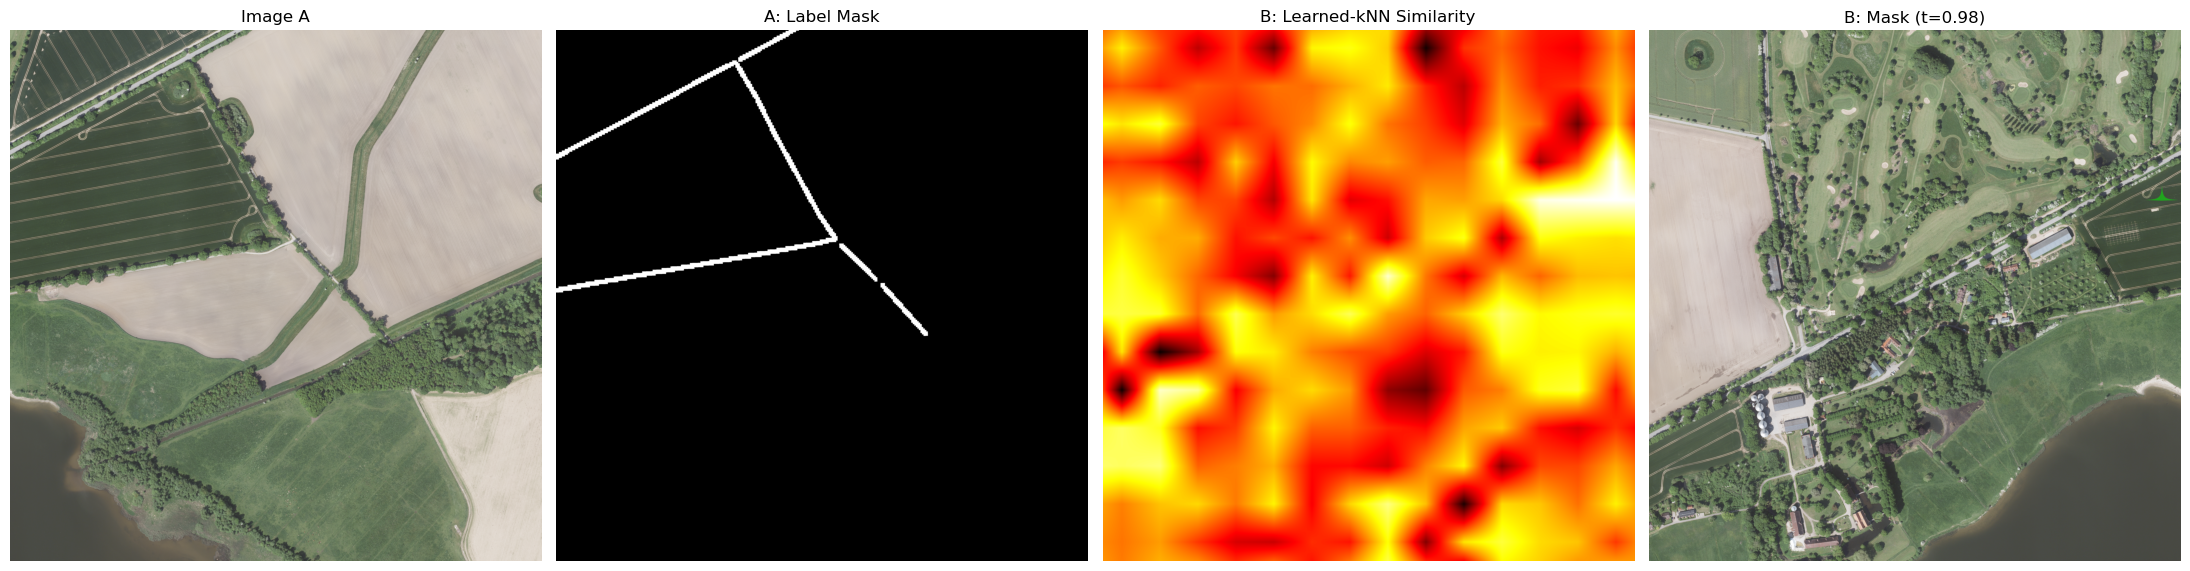

{'bank_size': 1,
 'score_map_b_patch': array([[0.97128665, 0.963961  , 0.9566817 , 0.96253926, 0.95251167,
         0.9715791 , 0.9725532 , 0.9695265 , 0.948462  , 0.96214426,
         0.9644953 , 0.9605015 , 0.9590592 , 0.96652275],
        [0.96390504, 0.961417  , 0.96427023, 0.9631641 , 0.96533054,
         0.96495974, 0.9681766 , 0.9710561 , 0.9614793 , 0.9565246 ,
         0.96658015, 0.9612107 , 0.9620608 , 0.96888596],
        [0.9708233 , 0.9737238 , 0.9630016 , 0.96073544, 0.9639454 ,
         0.9663176 , 0.972362  , 0.96532845, 0.9627981 , 0.95840216,
         0.9682855 , 0.9649295 , 0.95262563, 0.97005796],
        [0.9625978 , 0.9607113 , 0.9565121 , 0.96972096, 0.9594097 ,
         0.9718618 , 0.96622527, 0.96736056, 0.96423423, 0.96463037,
         0.9739215 , 0.9553205 , 0.9638222 , 0.97973776],
        [0.96724   , 0.97027814, 0.9631196 , 0.9630509 , 0.95618093,
         0.97086024, 0.95845383, 0.9604536 , 0.96778715, 0.9673867 ,
         0.97028214, 0.97932035, 0.97979

In [28]:
# --------------- Example run ---------------
img_b = np.array(Image.open(img2).convert("RGB"))
run_zero_shot_transfer_learned(img, labels_2d, img_b, model, processor, device,
                         k=8, threshold=0.98, erode_pixels=2,
                         aggregate_layers=[-i for i in range(0,15)])

In [29]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from skimage.transform import resize
import matplotlib.pyplot as plt

# ----------------- basic helpers -----------------

def l2_normalize(feats, eps=1e-8):
    """
    L2-normalize features along the last dimension.
    This is standard before cosine-sim / kNN with cosine metric.
    """
    norms = np.linalg.norm(feats, axis=-1, keepdims=True) + eps
    return feats / norms


def tile_iterator(image_hw3, labels_hw=None, tile_size=1024, stride=None):
    """
    Generator that yields tiles (and label tiles) from a large image.
    This is the standard sliding-window / tiling used in high-res ViT RS.
    """
    H, W = image_hw3.shape[:2]
    if stride is None:
        stride = tile_size

    for y in range(0, max(H - tile_size + 1, 1), stride):
        for x in range(0, max(W - tile_size + 1, 1), stride):
            y_end = min(y + tile_size, H)
            x_end = min(x + tile_size, W)
            img_tile = image_hw3[y:y_end, x:x_end]
            if labels_hw is not None:
                lab_tile = labels_hw[y:y_end, x:x_end]
            else:
                lab_tile = None
            yield y, x, img_tile, lab_tile


def crop_to_multiple_of_ps(img_tile_hw3, labels_tile_hw, ps):
    """
    Crop image and labels so H and W are exact multiples of patch size ps.
    This avoids the model or processor silently cropping internally.
    """
    H, W = img_tile_hw3.shape[:2]
    H_eff = (H // ps) * ps
    W_eff = (W // ps) * ps
    img_c = img_tile_hw3[:H_eff, :W_eff]
    lab_c = labels_tile_hw[:H_eff, :W_eff] if labels_tile_hw is not None else None
    return img_c, lab_c, H_eff, W_eff


def labels_to_patch_masks(labels_tile, Hp, Wp, pos_frac_thresh=0.1):
    """
    Convert pixel-level labels to patch-level positive/negative masks
    using patch-wise pooling (majority / any-positive vote).
    This preserves thin linear structures better than resize().
    """
    H_eff, W_eff = labels_tile.shape
    patch_h = H_eff // Hp
    patch_w = W_eff // Wp

    labels_c = labels_tile[:Hp * patch_h, :Wp * patch_w]
    labels_bin = (labels_c > 0).astype(np.float32)

    blocks = labels_bin.reshape(Hp, patch_h, Wp, patch_w)
    frac_pos = blocks.mean(axis=(1, 3))  # (Hp, Wp)

    pos_mask = frac_pos >= pos_frac_thresh
    neg_mask = frac_pos == 0.0
    return pos_mask, neg_mask


# ----------------- DINOv3 feature extraction (single + multi-scale) -----------------

def extract_patch_features_single_scale(
    image_hw3,
    model,
    processor,
    device,
    ps=16,
    aggregate_layers=None,
):
    """
    Extract DINOv3 patch features for a single scale.
    We disable internal resizing/cropping in the processor and rely
    on external cropping to multiples of ps.
    Returns:
        feats: (Hp, Wp, C) numpy, L2-normalized
        Hp, Wp: patch-grid size
    """
    # processor: keep resolution
    inputs = processor(
        images=image_hw3,
        return_tensors="pt",
        do_resize=False,
        do_center_crop=False
    ).to(device)

    px = inputs["pixel_values"]
    _, _, Hproc, Wproc = px.shape

    with torch.no_grad():
        if aggregate_layers is None:
            out = model(**inputs)
            tokens = out.last_hidden_state
        else:
            out = model(**inputs, output_hidden_states=True)
            hs = out.hidden_states
            layers = [hs[i] for i in aggregate_layers]
            tokens = torch.stack(layers, dim=0).mean(0)

    R = getattr(model.config, "num_register_tokens", 0)
    patch_tokens = tokens[:, 1 + R:, :]  # drop CLS + registers

    N, C = patch_tokens.shape[1], patch_tokens.shape[2]
    Hp = Hproc // ps
    Wp = Wproc // ps
    assert Hp * Wp == N, f"Patch-grid mismatch: {Hp}*{Wp} != {N}"

    feats = patch_tokens[0].cpu().numpy().reshape(Hp, Wp, C)
    feats = l2_normalize(feats)
    return feats, Hp, Wp


def extract_multiscale_patch_features(
    image_hw3,
    model,
    processor,
    device,
    ps=16,
    scales=(1.0, 0.5),
    aggregate_layers=None,
):
    """
    Multi-scale feature extraction:
    - For each scale, resize image, run DINOv3, get patch-grid features.
    - Upsample all scales to the highest-resolution grid and average.
    """
    H, W = image_hw3.shape[:2]
    feats_acc = None
    Hp_base = Wp_base = None

    for s in scales:
        if s != 1.0:
            Hs = int(round(H * s))
            Ws = int(round(W * s))
            img_s = resize(
                image_hw3,
                (Hs, Ws),
                order=1,
                preserve_range=True,
                anti_aliasing=True
            ).astype(image_hw3.dtype)
        else:
            img_s = image_hw3

        feats_s, Hp_s, Wp_s = extract_patch_features_single_scale(
            img_s, model, processor, device, ps=ps,
            aggregate_layers=aggregate_layers
        )

        if feats_acc is None:
            # use the highest-res scale as base
            Hp_base, Wp_base = Hp_s, Wp_s
            feats_acc = feats_s
        else:
            # upsample to base grid
            feats_up = resize(
                feats_s,
                (Hp_base, Wp_base),
                order=1,
                preserve_range=True,
                anti_aliasing=True
            )
            feats_acc += feats_up

    feats_acc = l2_normalize(feats_acc)
    return feats_acc, Hp_base, Wp_base


# ----------------- Bank building from Image A -----------------

def build_banks_multiscale(
    img_a,
    labels_a,
    model,
    processor,
    device,
    ps=16,
    tile_size=1024,
    stride=None,
    scales=(1.0, 0.5),
    pos_frac_thresh=0.1,
    aggregate_layers=None,
):
    """
    Build positive and negative feature banks from Image A using multi-scale DINOv3.
    Operates over tiles to handle large images.
    """
    pos_list = []
    neg_list = []

    for y, x, img_tile, lab_tile in tile_iterator(img_a, labels_a, tile_size, stride):
        # crop tile to multiples of patch size
        img_c, lab_c, H_eff, W_eff = crop_to_multiple_of_ps(img_tile, lab_tile, ps)
        if H_eff < ps or W_eff < ps:
            continue  # tile too small after cropping

        # multi-scale features
        feats_tile, Hp, Wp = extract_multiscale_patch_features(
            img_c, model, processor, device, ps=ps,
            scales=scales, aggregate_layers=aggregate_layers
        )

        # labels -> patch masks
        pos_mask, neg_mask = labels_to_patch_masks(lab_c, Hp, Wp,
                                                   pos_frac_thresh=pos_frac_thresh)

        pos_feats_tile = feats_tile[pos_mask]   # (N_pos_tile, C)
        neg_feats_tile = feats_tile[neg_mask]   # (N_neg_tile, C)

        if pos_feats_tile.size > 0:
            pos_list.append(pos_feats_tile)
        if neg_feats_tile.size > 0:
            neg_list.append(neg_feats_tile)

    if len(pos_list) == 0:
        raise ValueError("No positive patches found in Image A. Check labels/threshold.")

    pos_bank = np.concatenate(pos_list, axis=0)
    neg_bank = np.concatenate(neg_list, axis=0) if len(neg_list) > 0 else None

    print(f"Positive bank size: {len(pos_bank)} patches")
    if neg_bank is not None:
        print(f"Negative bank size: {len(neg_bank)} patches")

    return pos_bank, neg_bank


# ----------------- Zero-shot scoring on Image B (multiscale, tiled) -----------------

def zero_shot_knn_multiscale_B(
    img_b,
    pos_bank,
    model,
    processor,
    device,
    ps=16,
    tile_size=1024,
    stride=None,
    scales=(1.0, 0.5),
    k=5,
    aggregate_layers=None,
):
    """
    Apply zero-shot kNN transfer to Image B using the positive bank built from A.
    Produces a full-resolution similarity map over B.
    """
    H_full, W_full = img_b.shape[:2]
    score_full = np.zeros((H_full, W_full), dtype=np.float32)
    weight_full = np.zeros((H_full, W_full), dtype=np.float32)

    # fit kNN on pos_bank
    nn = NearestNeighbors(
        n_neighbors=min(k, max(1, len(pos_bank))),
        metric="cosine",
        algorithm="brute"
    )
    nn.fit(pos_bank)

    for y, x, img_tile, _ in tile_iterator(img_b, None, tile_size, stride):
        img_c, _, H_eff, W_eff = crop_to_multiple_of_ps(img_tile, None, ps)
        if H_eff < ps or W_eff < ps:
            continue

        feats_tile, Hp, Wp = extract_multiscale_patch_features(
            img_c, model, processor, device, ps=ps,
            scales=scales, aggregate_layers=aggregate_layers
        )

        X = feats_tile.reshape(-1, feats_tile.shape[-1])  # Nb_patches × C
        dists, _ = nn.kneighbors(X, return_distance=True)
        sims = 1.0 - dists
        score_patch = sims.mean(axis=1).reshape(Hp, Wp)

        # upsample patch scores to pixel grid of tile
        score_tile = resize(
            score_patch,
            (H_eff, W_eff),
            order=1,
            preserve_range=True,
            anti_aliasing=True
        ).astype(np.float32)

        # accumulate into full map
        score_full[y:y+H_eff, x:x+W_eff] += score_tile
        weight_full[y:y+H_eff, x:x+W_eff] += 1.0

    # avoid division by zero
    mask_nonzero = weight_full > 0
    score_full[mask_nonzero] /= weight_full[mask_nonzero]

    return score_full


# ----------------- Top-level runner & visualization -----------------

def run_zero_shot_transfer_multiscale(
    img_a,
    labels_a,
    img_b,
    model,
    processor,
    device,
    ps=16,
    tile_size=1024,
    stride=None,
    scales=(1.0, 0.5),
    k=5,
    pos_frac_thresh=0.1,
    threshold=0.75,
    aggregate_layers=None,
    use_crf=False,
    refine_with_crf=None,    # optional callback if you have CRF routine
):
    """
    End-to-end:
    - build multi-scale positive bank from A
    - score B via multi-scale kNN
    - threshold & (optionally) CRF
    - visualize
    """
    # 1) build banks from A
    pos_bank, neg_bank = build_banks_multiscale(
        img_a, labels_a,
        model, processor, device,
        ps=ps,
        tile_size=tile_size,
        stride=stride,
        scales=scales,
        pos_frac_thresh=pos_frac_thresh,
        aggregate_layers=aggregate_layers,
    )

    # 2) score B
    score_full = zero_shot_knn_multiscale_B(
        img_b,
        pos_bank,
        model, processor, device,
        ps=ps,
        tile_size=tile_size,
        stride=stride,
        scales=scales,
        k=k,
        aggregate_layers=aggregate_layers,
    )

    # 3) threshold
    mask_b = score_full >= threshold

    # 4) optional CRF refinement
    if use_crf and refine_with_crf is not None:
        coarse_labels = mask_b.astype(np.int32)
        refined = refine_with_crf(img_b.astype(np.uint8), coarse_labels, n_classes=2)
        mask_b = (refined == 1)

    # 5) visualization
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))
    axs[0].imshow(img_a)
    axs[0].set_title("Image A")
    axs[0].axis("off")

    axs[1].imshow(labels_a > 0, cmap="gray")
    axs[1].set_title("A: Label Mask")
    axs[1].axis("off")

    axs[2].imshow(img_b)
    axs[2].imshow(mask_b, cmap="Greens", alpha=0.4)
    axs[2].set_title(f"B: Zero-shot multi-scale mask (t={threshold})")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    return dict(
        pos_bank=pos_bank,
        neg_bank=neg_bank,
        score_full=score_full,
        mask_b=mask_b,
    )


Positive bank size: 6694 patches
Negative bank size: 254946 patches


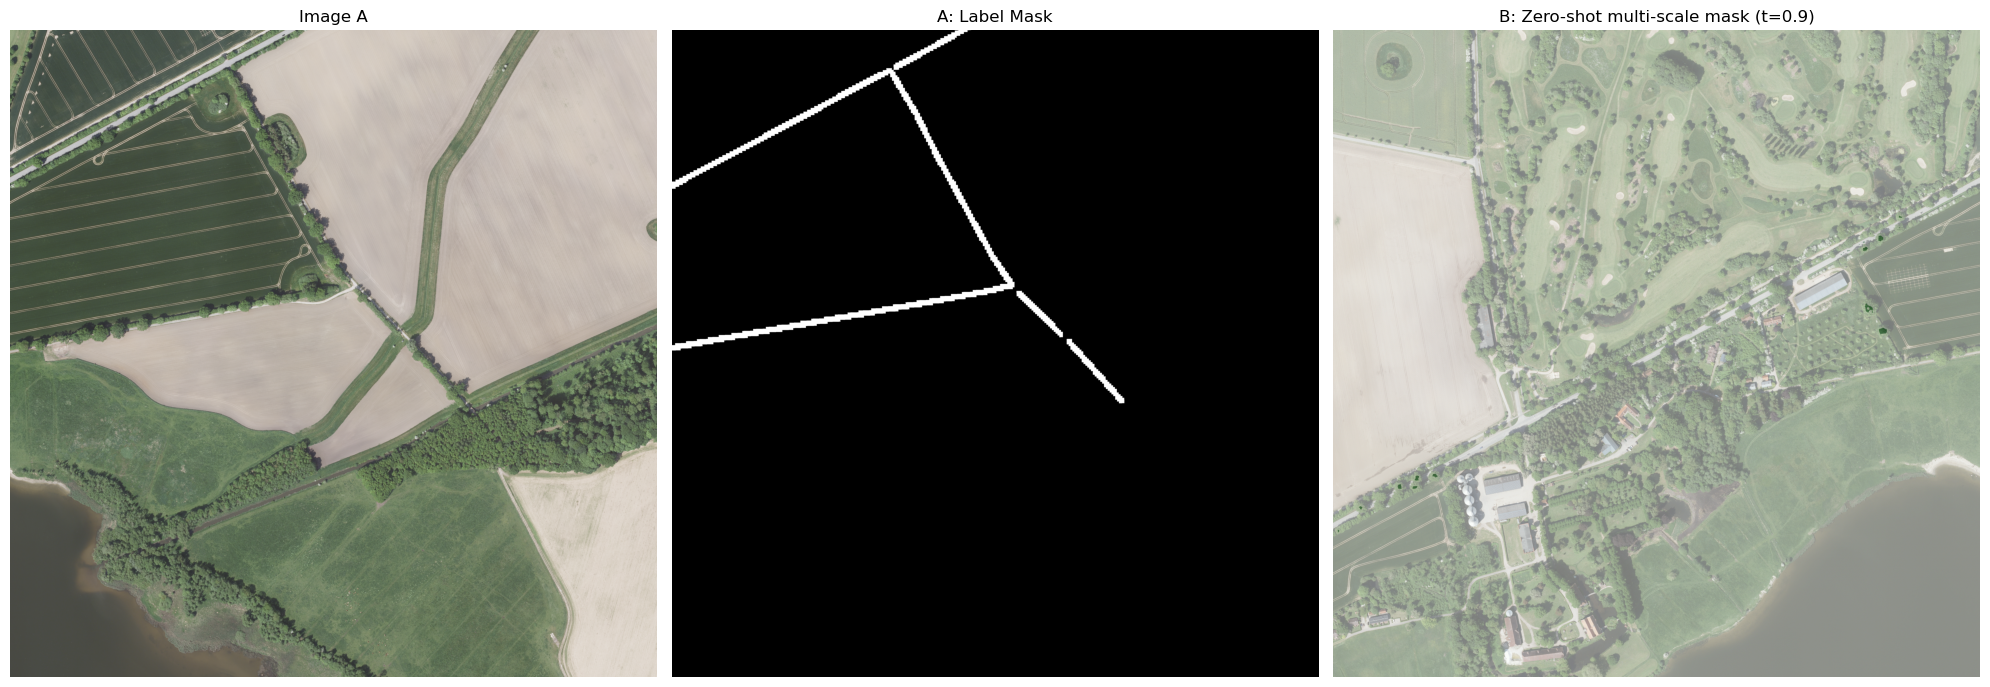

In [41]:
result = run_zero_shot_transfer_multiscale(
    img_a       = img,          # your DOP20 tile for A
    labels_a    = labels_2d,    # reprojected Planet mask aligned to img
    img_b       = img_b,        # another DOP20 tile
    model       = model,
    processor   = processor,
    device      = device,
    ps          = model.config.patch_size,  # 16 for dinov3-vitl16-sat493m
    tile_size   = 1024,
    stride      = 512,
    scales      = (1.0, 0.8),
    k           = 6,
    pos_frac_thresh = 0.1,
    threshold   = 0.8,
    aggregate_layers = None,
)


# Zero-Shot Multi-Scale Patch-Bank Transfer Using DINOv3-SAT

## Overview

This method performs **zero-shot transfer of linear-woody-feature (LWF) segmentation** from a labelled source image (A) to an unlabelled target image (B).
The system relies on **DINOv3-SAT**, a self-supervised Vision Transformer pre-trained on 493M satellite image patches, used strictly as a **frozen feature extractor**.
High-resolution remote sensing images are processed using **tiling**, **multi-scale feature extraction**, and **patch-wise label pooling** to construct a **prototype bank of positive LWF patches**.
Segmentation on B is derived via **k-nearest-neighbour (kNN) similarity** to this bank.

The pipeline is non-parametric (no training beyond feature extraction), scale-robust, and suitable for large orthoimagery.

---

## 1. Tiling of High-Resolution Images

DINOv3 operates at moderate input sizes (224–518 px).
To preserve local detail in ~20 cm GSD aerial imagery, both A and B are decomposed into **fixed-size tiles**:

```
for y,x in grid:
    tile_A  ← image_A[y:y+T, x:x+T]
    tile_lab← labels_A[y:y+T, x:x+T]   # only for A
    tile_B  ← image_B[y:y+T, x:x+T]
```

* Typical choice: `T = 1024` px
* Optional overlap (`stride < T`) ensures boundary continuity
* Tiles are cropped so that both height and width are divisible by the ViT patch size (`ps = 16`)

This eliminates uncontrolled resizing inside the model’s processor.

---

## 2. Multi-Scale Feature Extraction with DINOv3-SAT

For each tile, features are computed at multiple image scales to improve robustness to structure thickness and perspective variability.

Let `S = {1.0, 0.5}` denote the set of scales.

For each scale `s ∈ S`:

1. Resize tile:

   ```
   I_s = resize(I, scale=s)
   ```
2. Extract patch embeddings using DINOv3-SAT (frozen):

   ```
   F_s ∈ ℝ^{Hp_s × Wp_s × C}
   ```
3. Upsample `F_s` to the highest-resolution patch grid, `H_base × W_base`.

All scale embeddings are **summed**, then L2-normalized:

```
F = Normalize( Σ_s  Upsample(F_s) )
```

This yields one multi-scale representation per tile.

---

## 3. Patch-Wise Label Pooling for Image A

Pixel labels are mapped to patch labels without using `resize`, which is destructive for thin LWF structures.
Instead, each ViT patch receives a label based on the fraction of positive pixels inside its spatial extent.

Given label tile `L` and patch grid `(Hp, Wp)`:

```
Partition L into Hp×Wp blocks
FracPos[i,j] = mean( L(block i,j) > 0 )

Positive patch: FracPos ≥ τ_pos           (e.g., 0.05 – 0.10)
Negative patch: FracPos = 0
```

This preserves sub-patch structures (e.g., vegetation lines only a few pixels wide).

All positive embeddings from all tiles are concatenated into a **positive patch bank**:

```
Bank_pos = { F_tile[i,j] | patch (i,j) is positive }
```

Negative patches may optionally be collected for diagnostics or later metric learning.

---

## 4. Zero-Shot Similarity Transfer to Image B

For each tile in B:

1. Compute its multi-scale embedding `F_B ∈ ℝ^{Hp×Wp×C}`
2. Flatten to patch list `X ∈ ℝ^{Nb×C}`
3. Compute k-nearest neighbours in the positive bank using cosine distance:

   ```
   dists, idx = kNN(X, Bank_pos, metric=cosine)
   sims = 1 − dists
   score_patch = mean_k(sims)
   ```
4. Upsample patch scores back to the pixel grid of the tile.

Tile scores are accumulated into a full-resolution score map:

```
Score_full[y:y+H,x:x+W] += score_tile
Weight[y:y+H,x:x+W]     += 1
Score_full /= Weight
```

This produces a dense similarity field over B.

---

## 5. Segmentation

A final binary mask is obtained by thresholding the similarity scores:

```
Mask_B = Score_full ≥ τ
```

Optionally, a **DenseCRF** or other spatial regularizer may be applied to refine edges and enforce connectivity of woody linear structures.

---

## 6. Algorithm Summary (Pseudo-Pipeline)

```
Input: Image A with labels LA, Image B, DINOv3-SAT
Output: Binary LWF mask on B

# A: Build positive patch bank
for tile in tiles(A):
    F_tile  ← multiscale_features(tile.image)
    P_tile  ← patch_label_pooling(tile.labels)
    Bank_pos.append(F_tile[P_tile == positive])

# B: Zero-shot inference
for tile in tiles(B):
    F_tile  ← multiscale_features(tile.image)
    score_tile ← kNN_similarity(F_tile, Bank_pos)
    write score_tile into Score_full

Mask_B ← Score_full ≥ threshold
```

---

## 7. Advantages

* **Zero training**: no fine-tuning required
* **High-resolution capable** via tiling
* **Scale-robust** via multi-scale embeddings
* **Label-faithful** due to patch-wise pooling instead of interpolation
* **Generalizable** to new areas and seasons via DINOv3-SAT’s self-supervised pretraining
* **Efficient**: kNN in moderately sized banks (10³–10⁴ vectors) is practical with brute-force cosine search

---

## 8. Limitations

* Patch-level resolution is still constrained by the ViT patch size
* Similarity transfer does not explicitly model structure continuity; optional CRF/skeletonization may be required
* Bank quality depends on the representativeness of Image A’s labels
* Multi-scale processing increases computational cost linearly in the number of scales

